# Smash Bros

Today's extra nerdy dataset is stats from a tournament of the game *Super Smash Bros. Melee* for the Nintendo GameCube.  The stats were recorded during the tournament [Smash Summit 2017](https://liquipedia.net/smash/Smash_Summit/Spring_2017), these stats were collected by an older version the [Slippi](https://slippi.gg/faq) project.  The data was collected with this [R script](https://github.com/AdamSpannbauer/twitch_chat/blob/master/r_scripts/slippi_win.R) in 2017 (no promises the script still works).

The data contains a player id column, `gamerTag`, and a binary variable indicating if the player won the set: `won`.  The rest of the variables are different statistics counted up throughout the set. 

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


data_url = "https://raw.githubusercontent.com/AdamSpannbauer/twitch_chat/master/data/slippi_data/ssbm_win.csv"
ssbm = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Complete the below function to show the biggest offenders for NAs in a `pandas.DataFrame` (i.e. show the top n columns by number or percent of `np.nan` values in the column).

* Give the `n` parameter a default value of `5`
* Give the `rate` parameter a default boolean value
* Fill in the blanks to match what the comments are saying

In [4]:
ssbm.head()

,gamerTag,numCombosStarted,totalComboDamage,averageComboDamage,maxComboDamage,percentTimeClosestCenter,percentTimeInShield,rollCount,numRecoveries,totalRecoveryDamage,...,numEdgeguards,numFailedEdgeguards,edgeguardSuccessPercent,numPunishesStarted,numKillingPunishes,totalPunishDamage,averagePunishDamage,neutralWinPercent,openingsPerKill,won
0,S2J,79,1119.17,14.166709,37.92,53.205737,7.801918,43,23,375.85,...,24,23,4.166667,66,9,1124.17,17.032879,45.833333,7.333333,0.0
1,Hungrybox,101,1724.49,17.074158,89.08,46.794263,3.151007,7,24,94.10,...,23,11,52.173913,78,15,1724.49,22.108846,54.166667,5.200000,1.0
2,Leffen,74,1226.34,16.572162,66.09,53.446289,3.783666,13,20,269.00,...,22,13,40.909091,50,11,1229.34,24.586800,53.763441,4.545455,1.0
3,PewPewU,60,912.56,15.209333,66.24,46.553711,1.933133,4,22,240.41,...,20,15,25.000000,43,6,913.56,21.245581,46.236559,7.166667,0.0
4,Infinite Numbers,53,932.94,17.602642,140.80,51.024071,8.328259,9,26,499.92,...,14,13,7.142857,45,5,932.94,20.732000,39.473684,9.000000,0.0


<IPython.core.display.Javascript object>

In [6]:
def show_top_missing(df, n=5, rate=False):
    """Utility to print most 'sparse' columns by missing values"""

    # Create a boolean df indicating which values are np.nan
    is_na_df = df.isna()

    # Aggregate the df:
    # * if rate is true, then calculate what percent of values are nan
    # * if rate is false, then calculate the count of nans
    if rate:
        missing_stats = is_na_df.mean()
    else:
        missing_stats = is_na_df.sum()

    top_missing = missing_stats.sort_values(ascending=False)

    # We might consider to return or print here
    # If we wanted to work with the output values, we'd want
    # to use return.  I just wanted to see a display of the
    # output so I chose print instead.
    print(top_missing.head(n))

<IPython.core.display.Javascript object>

In [7]:
# If you followed ALL the prompts for the function
# this code should run without error. If you get an
# error about "missing required positional arguments"
# then you need to check that you set default values
# for n and rate.

show_top_missing(ssbm)
ssbm.head()

won                   0
openingsPerKill       0
numCombosStarted      0
totalComboDamage      0
averageComboDamage    0
dtype: int64


,gamerTag,numCombosStarted,totalComboDamage,averageComboDamage,maxComboDamage,percentTimeClosestCenter,percentTimeInShield,rollCount,numRecoveries,totalRecoveryDamage,...,numEdgeguards,numFailedEdgeguards,edgeguardSuccessPercent,numPunishesStarted,numKillingPunishes,totalPunishDamage,averagePunishDamage,neutralWinPercent,openingsPerKill,won
0,S2J,79,1119.17,14.166709,37.92,53.205737,7.801918,43,23,375.85,...,24,23,4.166667,66,9,1124.17,17.032879,45.833333,7.333333,0.0
1,Hungrybox,101,1724.49,17.074158,89.08,46.794263,3.151007,7,24,94.10,...,23,11,52.173913,78,15,1724.49,22.108846,54.166667,5.200000,1.0
2,Leffen,74,1226.34,16.572162,66.09,53.446289,3.783666,13,20,269.00,...,22,13,40.909091,50,11,1229.34,24.586800,53.763441,4.545455,1.0
3,PewPewU,60,912.56,15.209333,66.24,46.553711,1.933133,4,22,240.41,...,20,15,25.000000,43,6,913.56,21.245581,46.236559,7.166667,0.0
4,Infinite Numbers,53,932.94,17.602642,140.80,51.024071,8.328259,9,26,499.92,...,14,13,7.142857,45,5,932.94,20.732000,39.473684,9.000000,0.0


<IPython.core.display.Javascript object>

Create some visualization(s) in light of the goal (predicting win).  Based on the visualization, what do you think will be a good predictor?

In [24]:
ssbm.corr().columns[-1]

'won'

<IPython.core.display.Javascript object>

In [25]:
ssbm.corr().loc[ssbm.corr().columns[-1], :]

numCombosStarted            0.273256
totalComboDamage            0.319114
averageComboDamage          0.008225
maxComboDamage             -0.004142
percentTimeClosestCenter    0.064556
percentTimeInShield        -0.331849
rollCount                  -0.040098
numRecoveries              -0.191162
totalRecoveryDamage        -0.397949
averageRecoveryDamage      -0.320945
maxRecoveryDamage          -0.173356
numSuccessfulRecoveries     0.051498
recoverySuccessPercent      0.501261
numEdgeguards               0.292374
numFailedEdgeguards         0.036933
edgeguardSuccessPercent     0.498506
numPunishesStarted          0.141838
numKillingPunishes          0.553108
totalPunishDamage           0.319304
averagePunishDamage         0.316889
neutralWinPercent           0.490021
openingsPerKill            -0.536008
won                         1.000000
Name: won, dtype: float64

<IPython.core.display.Javascript object>

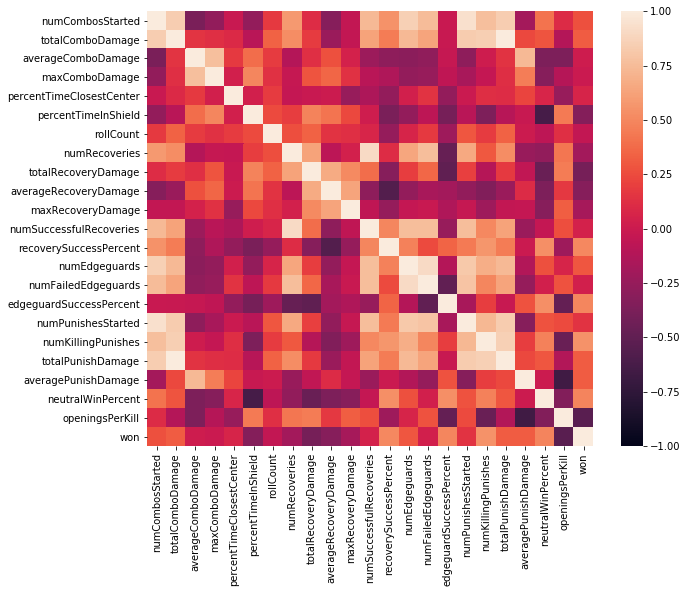

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(ssbm.corr(), vmin=-1, vmax=1, annot=False)
plt.show()

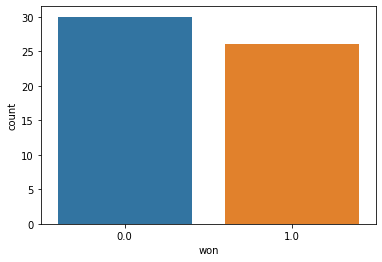

<IPython.core.display.Javascript object>

In [26]:
sns.countplot(ssbm["won"])

In [28]:
ssbm.columns

Index(['gamerTag', 'numCombosStarted', 'totalComboDamage',
       'averageComboDamage', 'maxComboDamage', 'percentTimeClosestCenter',
       'percentTimeInShield', 'rollCount', 'numRecoveries',
       'totalRecoveryDamage', 'averageRecoveryDamage', 'maxRecoveryDamage',
       'numSuccessfulRecoveries', 'recoverySuccessPercent', 'numEdgeguards',
       'numFailedEdgeguards', 'edgeguardSuccessPercent', 'numPunishesStarted',
       'numKillingPunishes', 'totalPunishDamage', 'averagePunishDamage',
       'neutralWinPercent', 'openingsPerKill', 'won'],
      dtype='object')

<IPython.core.display.Javascript object>

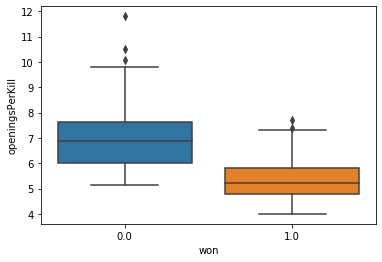

<IPython.core.display.Javascript object>

In [29]:
sns.boxplot("won", "openingsPerKill", data=ssbm)

In most machine learning contexts, we will isolate our input features from our target variable.  Player ID won't be much use since we want our model to predict wins for every player, not just the 16 players in our data set.

* So we'll drop `gamerTag` & `won` and assign it to `X`
    * This `X` is a conventional way to specify that this variable is our input features
* It's also conventional to put your target into a variable named `y`

In [30]:
# Store every column but 'gamerTag' and 'won' in X
X = ssbm.drop(columns=["gamerTag", "won"])

# Store what you want to predict ('won') in y
y = ssbm["won"]

<IPython.core.display.Javascript object>

Let's go ahead and try to build our first model to predict this win.  Since the topic at hand is feature selection, we won't really discuss the model being used (yet); we'll just use it as a way to grade our features.  Note, this model building is also not following the best practice of doing a train/test split to evaluate accuracy.

In [31]:
model = LogisticRegression()
model.fit(X, y)
# In practice score on a test set
model.score(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9642857142857143

<IPython.core.display.Javascript object>

We see we ran into a `ConvergenceWarning`(note that it tells us some possible solutions to this issue).  Despite this issue we ended up predicting with ~95% accuracy.

*Note, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*

## Feature Selection

We might be able to avoid this warning by narrowing down our features.  Narrowing down features has a lot of benefits, including:
* Aiding in computation issues (RE:above warning)
* Aiding in accuracy
    * Can be a direct result from helping first point
* Aiding in interpretability
    * A lot of times you're not only interested in predicting something accurately, but also explaining why you're good at making these predictions.  For example, in a business context you might want to accurately predict customer churn, but you're management would also really like to know what is indicating that a customer is going to churn.  With an easily interpretable model you can show the impact each input feature has on a customer's likelihood to churn.  With a lot of predictors this gets harder to parse out.
    * There's also an issue known as [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).  This intuitively means that some of your input features are encoding the same information (like having a feature for `temperature_celsius` & one for `temperature_farenheit`).  When your model has multiple variables representing the same thing it can confuse the model, the model might still be accurate, but it will have more trouble explaining to you why it's accurate.
    
In this case, a way we can smartly select a subset of predictors is with `SelectKBest` with the `f_classif` method.  If you remember, ANOVA outputs a value called $F$, this is what the `f` in `f_classif` represents.  All we're doing here is running an ANOVA for each of our variables and target.

Our target variable is a category and all our predictors are numeric, so for each numeric feature we run an ANOVA using the target as the groups.  Below is an example using the feature `numKillingPunishes`.  To start we might visualize the differences between the 2 groups.  We see some difference, but we can quantify this difference using the `stats.f_oneway` function we've used before to perform an ANOVA.  We end up with an $F$ value of about `23.8`.

Note, we didn't really check for normality here.  ANOVA is fairly robust against violations of the normality assumption. Also, in the case variable selection, we aren't trying to declare any significant difference, we're just looking for potentially useful differences.

Perform an ANOVA for the `numKillingPunishes` feature grouped by `won`.

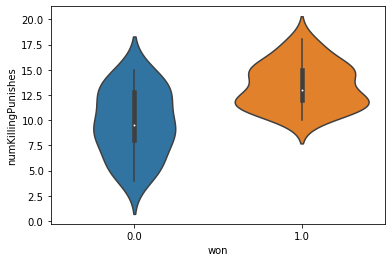

<IPython.core.display.Javascript object>

In [32]:
sns.violinplot("won", "numKillingPunishes", data=ssbm)
plt.show()

In [33]:
won = ssbm[ssbm["won"] == 1]
lost = ssbm[ssbm["won"] == 0]

stats.f_oneway(won["numKillingPunishes"], lost["numKillingPunishes"])

F_onewayResult(statistic=23.801775848225727, pvalue=9.83326076430818e-06)

<IPython.core.display.Javascript object>

So we've done an ANOVA for one of our variables, we can use `SelectKBest` from `sklearn` to do the rest.  It will:

* run the same ANOVA
* store all the values of $F$
* keep only the features with the top $k$ values of $F$

We have to select the value of $k$, and there's not a general rule of thumb on what it should be. Below, I chose 5 cause I wanted to it to choose the 5 best because ¯\\_(ツ)_/¯.

From the output, we can see the scores for each ANOVA that was run with `f_classif`, and we can confirm that we see the same value for `numKillingPunishes` as we did in our one variable example.

* Use `SelectKBest` and `f_classif` to choose the best 5 predictors of `won`
* Put these best predictors back into a dataframe with the original names

In [ ]:
k_best

In [36]:
X.columns[selector.get_support()]

Index(['recoverySuccessPercent', 'edgeguardSuccessPercent',
       'numKillingPunishes', 'neutralWinPercent', 'openingsPerKill'],
      dtype='object')

<IPython.core.display.Javascript object>

In [37]:
selector = SelectKBest(f_classif, k=5)

# Use `.fit()` method so the selector can 'learn' from our data
selector.fit(X, y)

# Use `.transform()` method so the selector can apply
# what it learned in `.fit()`
k_best = selector.transform(X)

# We can see/rank which features were the best
score_df = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
score_df = score_df.sort_values("f_score", ascending=False)
print(score_df.head())

# We can put back into a dataframe to see column names
best_df = pd.DataFrame(k_best, columns=X.columns[selector.get_support()])
best_df.head()

                    feature    f_score
17       numKillingPunishes  23.801776
21          openingsPerKill  21.768686
12   recoverySuccessPercent  18.121388
15  edgeguardSuccessPercent  17.857051
20        neutralWinPercent  17.063896


,recoverySuccessPercent,edgeguardSuccessPercent,numKillingPunishes,neutralWinPercent,openingsPerKill
0,47.826087,4.166667,9.0,45.833333,7.333333
1,95.833333,52.173913,15.0,54.166667,5.200000
2,75.000000,40.909091,11.0,53.763441,4.545455
3,59.090909,25.000000,6.0,46.236559,7.166667
4,53.846154,7.142857,5.0,39.473684,9.000000


<IPython.core.display.Javascript object>

We could now move back to modeling this data using the same code as before, but now providing only the 5 'best' features.

In [38]:
model = LogisticRegression()
model.fit(k_best, y)
# In practice score on a test set
model.score(k_best, y)

0.8928571428571429

<IPython.core.display.Javascript object>

With this restricted set, we didn't get a `ConvergenceWarning`. We do see a drop in accuracy, but this might actually be a sign that our first model was [*overfitting*](https://en.wikipedia.org/wiki/Overfitting).  Again, we can't take much from the score on our training data (see note below, and above, and everywhere).

However, we didn't lose too much accuracy despite deleting 19 of our input columns.  This shows that we likely have a lot of 'dead weight' in our features, and we can likely predict the outcome without having all 24 features to wade through (which can be a burden for both our model and us during interpretation).

*Note, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*

## PCA

In PCA (principle components anaylsis) we capture the variance of our data into 'components'.  What does that mean? Well, we'll be predicting our outcome based on how the other variables' values change (or vary).  So our model is really wanting to pick up on how the input features vary in relation to the outcome we're predicting.  PCA captures all this 'varying' in our data by combining our features, and it can capture this variance with less features than we started with.

Since we're really focused on how our features are varying, we `scale` them before doing PCA. Remember that `scale` will transform our inputs so that their means are 0 and their standard deviations are 1.  With all these standard deviations set to 1, none of the features will overpower the others in terms of their variance.  For example, the `totalComboDamage` has a variance of 188387.3 and `openingsPerKill` has a variance of 2.8, this is a big gap.  PCA is trying to maximize the amount of variation captured, and an easy way to shortcut this would be to focus in on features with larger variances; we want to put all our features on equal ground, and so we scale.

Below we see the effects of scaling on our features.

* Use the `StandardScaler()` to scale the data

In [40]:
print("Feature variances before scaling:")
print(X.var().sort_values(ascending=False).head())

scaler = StandardScaler()

# 'learn' from the data
scaler.fit(X)

# apply what the scaler learned
scaled_X = scaler.transform(X)
scaled_df = pd.DataFrame(scaled_X, columns=X.columns)

print("Feature variances after scaling:")
print(scaled_df.var().sort_values(ascending=False).head())

Feature variances before scaling:
totalComboDamage       188387.321222
totalPunishDamage      188083.438028
totalRecoveryDamage     20801.620480
numCombosStarted         1066.254221
maxComboDamage            962.982273
dtype: float64
Feature variances after scaling:
numCombosStarted       1.018182
totalRecoveryDamage    1.018182
averagePunishDamage    1.018182
totalComboDamage       1.018182
rollCount              1.018182
dtype: float64


<IPython.core.display.Javascript object>

Now we can move onto performing PCA.  To do this we can use `sklearn.decomposition.PCA`, and the main thing left for us to decide is how many components.  The reading focuses in on eigenvalues, here we'll use the variance explained and a scree plot.  I'd say the 'elbow' that we typically look for in a scree plot occurs after our 4th component.  So we might choose to set `n_components` to 4.

* Create a `PCA` object and apply it to the scaled data
* Plot the variance explained by each component
* Create a correlation heatmap of the prinicple components

In [42]:
dir(pca)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'singular_values_',
 'svd_solver',
 'tol',
 'transform',
 'whiten']

<IPython.core.display.Javascript object>

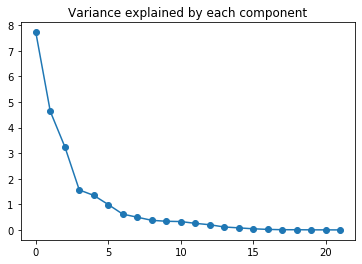

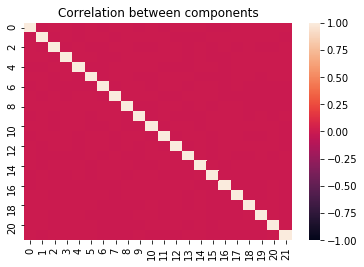

<IPython.core.display.Javascript object>

In [44]:
pca = PCA()

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

# What attribute holds the variance explained?
plt.plot(pca.explained_variance_, marker="o")
plt.title("Variance explained by each component")
plt.show()

sns.heatmap(pd.DataFrame(pca_X).corr(), vmin=-1, vmax=1)
plt.title("Correlation between components")
plt.show()

* Use what we learned from the scree plot to choose an appropriate number of components to use for the model

In [46]:
pca = PCA(n_components=4)

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

<IPython.core.display.Javascript object>

In [47]:
model = LogisticRegression()
model.fit(pca_X, y)
# In practice score on a test set
model.score(pca_X, y)

0.9107142857142857

<IPython.core.display.Javascript object>

So we went ahead and refit the model using our first 4 principle components.  We don't get a warning about convergence, and we seem to have a pretty decent fit (as judged by our bad scoring practice).  One thing to note about the model that was built.  It's going to be very hard to interpret.  We'll be able to see what effect each principle component has on the target variable.  This isn't the most intuitive thing to grasp, and it's even harder to explain to someone with a non-technical background.  PCA can sometimes be a positive in terms of model accuracy, but can also be a negative in terms of loss of iterpretability and understanding.

*Note, again, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*